## Context
Here, we modify the singlemetric tutorial code to handle multiple metrics. 
We were thinking of a few variations including the following:
- 1- Early Aggregation: Do anomaly scoring on each metric per service. Aggregate across metrics within service. Then, do modeling. 
- 2- Modify the graph: Include all of the metrics as nodes in the causal graph (somehow). In this case, we would ideally codify SME understanding of how different metrics may relate.
- 3- Graph filtering: Do anomaly scoring per metric. Only include 'certain metrics' based on heuristics (e.g. only include metrics in the graph that are anomalous on their own)
- 4- Per-metric-modeling: Formulate graph within a single metric. Run attribution one metric at a time. Then, aggregate attributions across analyses. 

We attempt 1 and 4 here. :) 

## Imports

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from scipy.stats import truncexpon, halfnorm, bernoulli
import json
import matplotlib.pyplot as plt

## Helpers

In [2]:
from red_causal_analyzer import *

/Users/by-gc-ia/opt/anaconda3/envs/py-dowhy/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Workspace

### Load data

In [3]:
data_dir = "simulated_multimetric_data"
normal_data_path = f"{data_dir}/normal_data.csv"
outlier_data_path = f"{data_dir}/anomalous_data.csv"
causal_graph_path = f"{data_dir}/causal_graph.json"
target_node_path = f"{data_dir}/target_node.txt"

def load_data(normal_data_path, outlier_data_path, causal_graph_path, target_node_path):
    normal_data = pd.read_csv(normal_data_path)
    outlier_data = pd.read_csv(outlier_data_path)
    with open(causal_graph_path, 'r') as f:
        causal_graph = nx.node_link_graph(json.load(f))
    with open(target_node_path, 'r') as f:
        target_node = f.read().strip()
    return normal_data, outlier_data, causal_graph, target_node

# Load data of interest
normal_data, outlier_data, causal_graph, target_node = load_data(normal_data_path, 
                                                                outlier_data_path, 
                                                                causal_graph_path, 
                                                                target_node_path)

/Users/by-gc-ia/opt/anaconda3/envs/py-dowhy/lib/python3.11/site-packages/networkx/readwrite/json_graph/node_link.py:287: FutureWarning: 
The default value will be changed to `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_graph(data, edges="links") to preserve current behavior, or
  nx.node_link_graph(data, edges="edges") for forward compatibility.
  warnings.warn(


### Attempt variation 1: Early aggregation

*First, compute anomaly scores on each metric. Then aggregate them into a single one*

In [4]:
# Initialize the AnomalyAggregator with z_score method
aggregator = AnomalyAggregator(detection_method='z_score')

# Fit the detectors using the normal data
aggregator.fit_detectors(normal_data)

# Calculate anomaly scores for the anomalous data
normal_data_ascores  = aggregator.calculate_anomaly_scores(normal_data).pivot(index='time_index', columns='service', values='anomaly_score')
anomaly_data_ascores = aggregator.calculate_anomaly_scores(outlier_data).pivot(index='time_index', columns='service', values='anomaly_score')

Text(0.5, 1.0, 'Normal data - mean anomaly score')

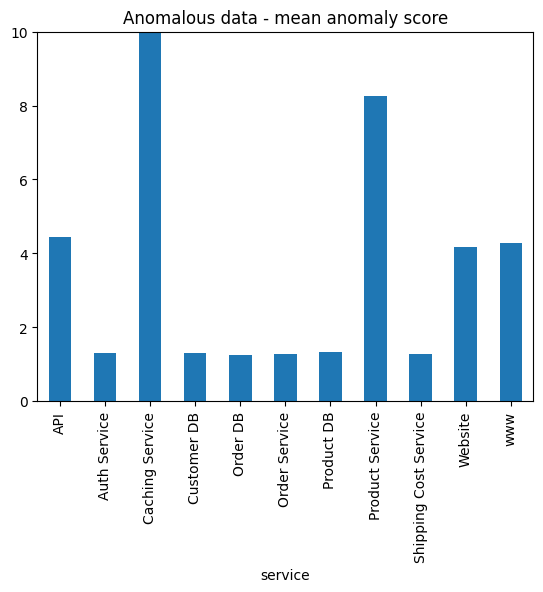

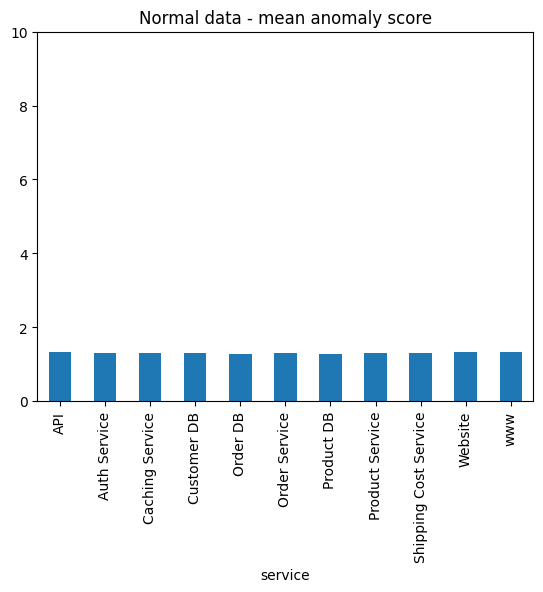

In [5]:
# Show mean anomaly scores
plt.figure()
ax = anomaly_data_ascores.mean().plot(kind='bar')
ax.set_ylim([0, 10])
plt.title('Anomalous data - mean anomaly score')

plt.figure()
ax = normal_data_ascores.mean().plot(kind='bar')
ax.set_ylim([0, 10])
plt.title('Normal data - mean anomaly score')

Note: in normal data, we don't expect deviation in anomaly score (lol as seen) but in anomalous, we would hope to see something in caching service and related nodes (yep! can see that).

Estimating Shapley Values. Average change of Shapley values in run 261 (1305 evaluated permutations): 1.420649668844795%: 100%|██████████| 1/1 [00:47<00:00, 47.98s/it]
Estimating Shapley Values. Average change of Shapley values in run 170 (850 evaluated permutations): 2.2580439609242084%: 100%|██████████| 1/1 [00:42<00:00, 42.94s/it]
Estimating Shapley Values. Average change of Shapley values in run 572 (2860 evaluated permutations): 0.7764797978227045%: 100%|██████████| 1/1 [00:49<00:00, 49.69s/it]
Estimating Shapley Values. Average change of Shapley values in run 763 (3815 evaluated permutations): 0.6456467741147679%: 100%|██████████| 1/1 [00:54<00:00, 54.96s/it]
Estimating bootstrap interval...: 100%|██████████| 4/4 [03:23<00:00, 50.96s/it]


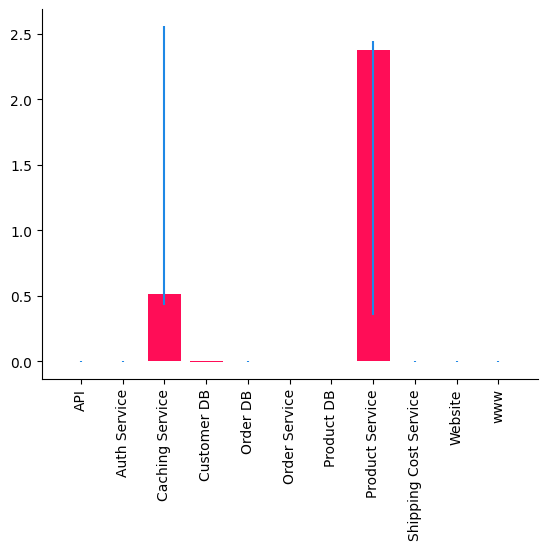

In [6]:
from causal_analyzer import CausalImpactAnalyzer

# Create an instance of the CausalImpactAnalyzer
analyzer = CausalImpactAnalyzer(discover_distributions=True, num_bootstrap_resamples=4)

# Load data and identify attributions
median_attribs, uncertainty_attribs = analyzer.identify_attributions(
    normal_data_ascores,
    anomaly_data_ascores, 
    causal_graph, 
    target_node
)

# Plot the attributions
_ = analyzer.plot_attributions(median_attribs, uncertainty_attribs)

In [12]:
def compute_percent_contrib(median_attribs):
    attribs_df = pd.DataFrame([median_attribs]).T.rename(columns = {0: 'median_attribs'}).abs()
    total_attribs_value = attribs_df['median_attribs'].sum()
    attribs_df['percent_contrib'] = attribs_df['median_attribs'] / total_attribs_value*100
    return attribs_df[['percent_contrib']]
compute_percent_contrib(median_attribs)

,percent_contrib
API,0.009921
Auth Service,0.012110
Caching Service,17.818536
Customer DB,0.093242
Order DB,0.004449
Order Service,0.003610
Product DB,0.136655
Product Service,81.769126
Shipping Cost Service,0.031347
Website,0.050455


### Attempt variation 4: Model attributions for each metric then aggregation across.

In [13]:
# Note: Before aggregating, we filter metrics to ones that are anomalous 
# (note: I put this lil hack in cause needa figure out how to account for non-anomalous metrics, here rate - which has no discernible difference with normal)

# Initialize the AnomalyAggregator with z_score method
aggregator = AnomalyAggregator(detection_method='z_score')

# Fit the detectors using the normal data
aggregator.fit_detectors(normal_data)

# Calculate anomaly scores for anomalous data
anomaly_data_ascores = aggregator.calculate_anomaly_scores(outlier_data)

In [14]:
# Here, we look at the z-score for each metric for each service. 
z_thresh = 2
agg_anomaly_ascores = anomaly_data_ascores.groupby('service')[['z_score__rate','z_score__error_rate','z_score__duration']].mean()
anomalous_service_metrics_df = agg_anomaly_ascores > z_thresh
anomalous_service_metrics_df

,z_score__rate,z_score__error_rate,z_score__duration
service,,,
API,False,True,True
Auth Service,False,False,False
Caching Service,False,True,True
Customer DB,False,False,False
Order DB,False,False,False
Order Service,False,False,False
Product DB,False,False,False
Product Service,False,True,True
Shipping Cost Service,False,False,False


In [18]:
# Subselect to metrics that are anomalous in at least one service
anomalous_metrics_series = anomalous_service_metrics_df.any()
anomalous_metrics = anomalous_metrics_series[anomalous_metrics_series].index.tolist()
anomalous_metrics = [m.replace('z_score__', '') for m in anomalous_metrics]

In [21]:
# Run analysis on each anomalous metric
results = {}
for metric in anomalous_metrics:
    analyzer = CausalImpactAnalyzer(discover_distributions=True, 
                                    num_bootstrap_resamples=2)
    median_attribs, uncertainty_attribs = analyzer.identify_attributions(
        normal_data.pivot(index='time_index', columns='service', values=metric),
        outlier_data.pivot(index='time_index', columns='service', values=metric), 
        causal_graph, 
        target_node
    )
    results[metric] = {
        'median_attribs': median_attribs,
        'uncertainty_attribs': uncertainty_attribs
    }

Estimating bootstrap interval...:   0%|          | 0/2 [00:00<?, ?it/s]

Estimating Shapley Values. Average change of Shapley values in run 124 (620 evaluated permutations): 1.0992831679935184%: 100%|██████████| 1/1 [00:41<00:00, 41.22s/it]
Estimating Shapley Values. Average change of Shapley values in run 177 (885 evaluated permutations): 1.209080966538227%: 100%|██████████| 1/1 [00:43<00:00, 43.80s/it]
Estimating bootstrap interval...: 100%|██████████| 2/2 [01:30<00:00, 45.27s/it]
Estimating Shapley Values. Average change of Shapley values in run 523 (2615 evaluated permutations): 1.1929587155786252%: 100%|██████████| 1/1 [00:55<00:00, 55.39s/it]
Estimating Shapley Values. Average change of Shapley values in run 266 (1330 evaluated permutations): 0.9153122158837457%: 100%|██████████| 1/1 [00:48<00:00, 48.66s/it]
Estimating bootstrap interval...: 100%|██████████| 2/2 [01:48<00:00, 54.40s/it]


In [22]:
def compute_percent_contrib(results, metric):
    attribs_df = pd.DataFrame(results[metric])[['median_attribs']].abs()
    total_attribs_value = attribs_df['median_attribs'].sum()
    attribs_df['percent_contrib'] = attribs_df['median_attribs'] / total_attribs_value*100
    return attribs_df[['percent_contrib']]

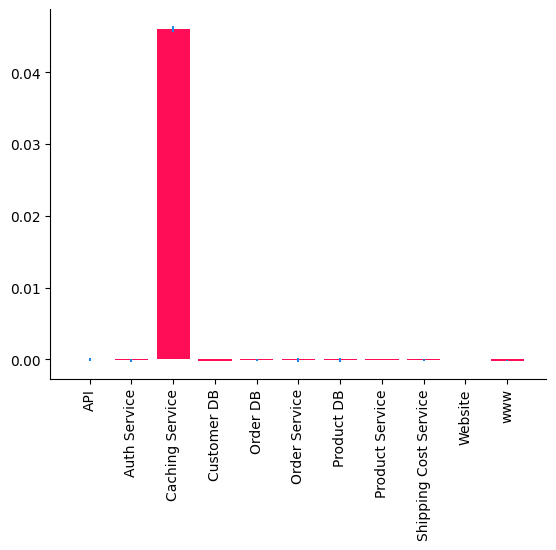

{'percent_contrib': {'Caching Service': 97.96517910684096}}

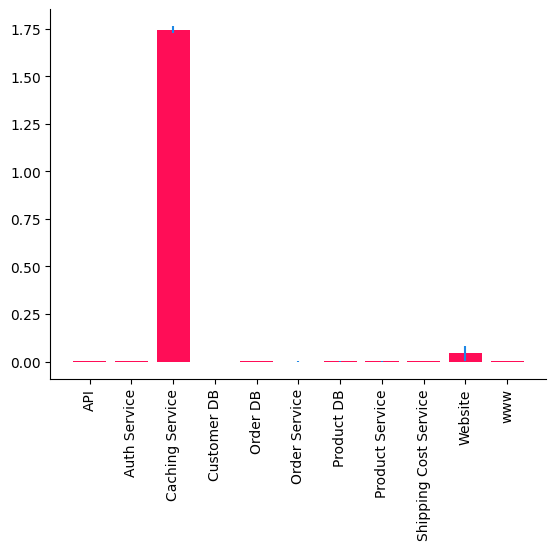

{'percent_contrib': {'Caching Service': 96.96090938873976}}

In [23]:
# Plot attributions for each metric and filter attributions to those with percentages greater than 20%
contribution_floor = 20 # percent
for metric in anomalous_metrics:
    plot_bytes = analyzer.plot_attributions(results[metric]['median_attribs'], results[metric]['uncertainty_attribs'])
    contributions = compute_percent_contrib(results, metric)
    significant_contributions = contributions[contributions['percent_contrib'] > contribution_floor]
    display(significant_contributions.to_dict())

### Sandbox (ignore below)

In [ ]:
from dowhy import gcm
from typing import Dict, Tuple

def analyze_root_cause(pivoted_scores: pd.DataFrame,
                       causal_graph: nx.DiGraph,
                       target_service: str) -> Tuple[Dict[str, float], object]:
    """
    Analyze root causes using GCM directly on anomaly scores.

    Args:
        anomaly_data: DataFrame with anomaly scores.
        causal_graph: The causal graph of the services.
        target_service: Service to analyze.

    Returns:
        Tuple of (attribution scores, fitted GCM model).
    """

    # Create and fit GCM model
    causal_model = gcm.StructuralCausalModel(causal_graph)


    # Set up causal mechanisms
    for node in causal_graph.nodes():
        parents = list(causal_graph.predecessors(node))
        if parents:
            # For nodes with parents, use linear regression
            causal_model.set_causal_mechanism(
                node,
                gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor())
            )
        else:
            # For root nodes, use empirical distribution
            causal_model.set_causal_mechanism(
                node,
                gcm.EmpiricalDistribution()
            )

    # Fit the model on the anomaly data
    gcm.fit(causal_model,pivoted_scores)

    strengths = gcm.intrinsic_causal_influence(causal_model, target_node = target_service, num_samples_randomization = 500)
    import numpy as np

    # Note: The percentage conversion only makes sense for purely positive attributions.
    def convert_to_percentage(value_dictionary):
        total_absolute_sum = np.sum([abs(v) for v in value_dictionary.values()])
        return {k: abs(v) / total_absolute_sum * 100 for k, v in value_dictionary.items()}
    from dowhy.utils import bar_plot

    bar_plot(convert_to_percentage(strengths), ylabel='Variance attribution in %')
    return strengths
